In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import emoji
%matplotlib inline

In [2]:
# parser
def parser(file_path):    
    pattern = re.compile(r'\[([\d\.\s:]+)\]\s([\S]+).*:\s([\S\s]+)')
    timestamps = list()
    names = list()
    messages = list()
    with open(file_path, "r") as f:
        for count, line in enumerate(f):
    #         print(line)
    #         line = line.strip()
    #         print(line)
            parser = pattern.match(line)
            if parser:
                t = parser.group(1).strip()
                n = parser.group(2).strip()
                m = parser.group(3).strip()
                timestamps.append(t)
                names.append(n)
                messages.append(m)
            else:
                # there are multi line messages. those will be added to the previous message body.
#                 print("Could not parse the line: {}\t{}".format(count, line))
                m = messages.pop()
                m = m + "\n" + line.strip()
                messages.append(m)
        print("Parsed {} lines".format(count))
    chat = pd.DataFrame(np.column_stack([timestamps, names, messages]),
                        columns=["Timestamp", "Name", "Message"])
    return chat

In [3]:
file_path = "../chat_data/h_chat.txt"
chat = parser(file_path)
chat["Date"] = chat["Timestamp"].apply(lambda x: datetime.datetime.strptime(x.split(" ")[0], "%d.%m.%Y").strftime("%d.%m.%Y"))
chat["Time"] = chat["Timestamp"].apply(lambda x: x.split(" ")[1])
# chat["Date"] = chat["Timestamp"].apply(lambda x: x.split(" ")[0])

Parsed 15740 lines


In [23]:
time_diff = [np.NAN]
print(time_diff)
for i in range(1, chat.shape[0]):
    diff = datetime.timedelta.total_seconds(datetime.datetime.strptime(chat.iloc[i]["Timestamp"], "%d.%m.%Y %H:%M:%S")-datetime.datetime.strptime(chat.iloc[i-1]["Timestamp"], "%d.%m.%Y %H:%M:%S"))
    time_diff.append(diff)

[nan]


In [25]:
chat["Time Difference"] = time_diff

<Container object of 2 artists>

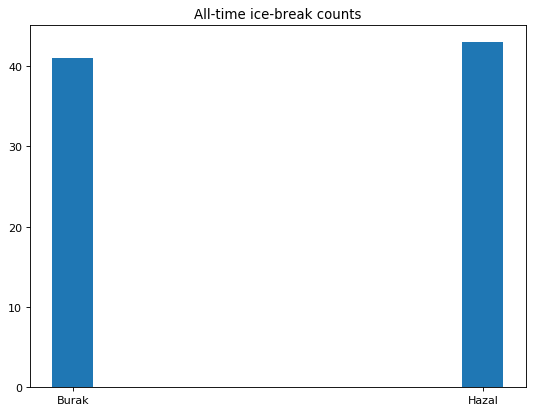

In [32]:
ice_breaks = chat[chat["Time Difference"]>21600].groupby("Name").count()["Message"].to_dict()
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("All-time ice-break counts")
plt.bar(x=list(ice_breaks.keys()), height=list(ice_breaks.values()), align='center', width=0.1)

([<matplotlib.patches.Wedge at 0x10b17a0f0>,
 [Text(0.0411304,1.09923,'Burak'), Text(-0.0411304,-1.09923,'Hazal')],
 [Text(0.0224347,0.59958,'48.8%'), Text(-0.0224347,-0.59958,'51.2%')])

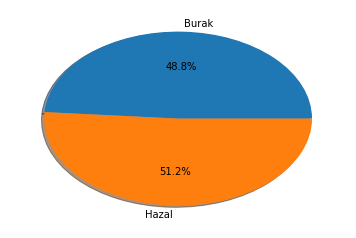

In [35]:
# plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.pie(x=list(ice_breaks.values()), labels=list(ice_breaks.keys()), autopct='%1.1f%%', shadow=True)

In [5]:
daily_m = chat.groupby(by=["Name", "Date"]).count()["Message"]
total_m_by_name = chat.groupby(by=["Name"]).count()["Message"].to_dict()
total_m_by_date = chat.groupby(by=["Date"]).count()["Message"].to_dict()

{'Burak': 8251, 'Hazal': 7440}


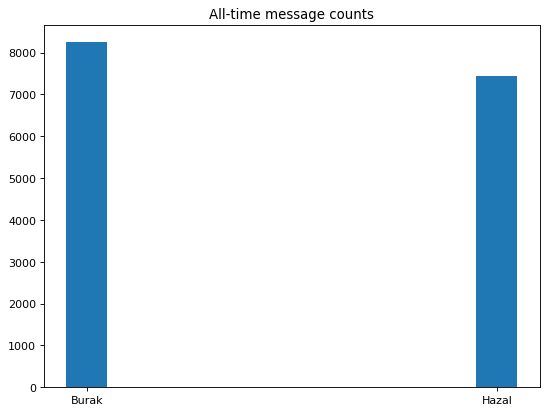

In [6]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("All-time message counts")
plt.bar(x=list(total_m_by_name.keys()), height=list(total_m_by_name.values()), align='center', width=0.1)
print(total_m_by_name)

Text(0.5,1,'Daily Messages')

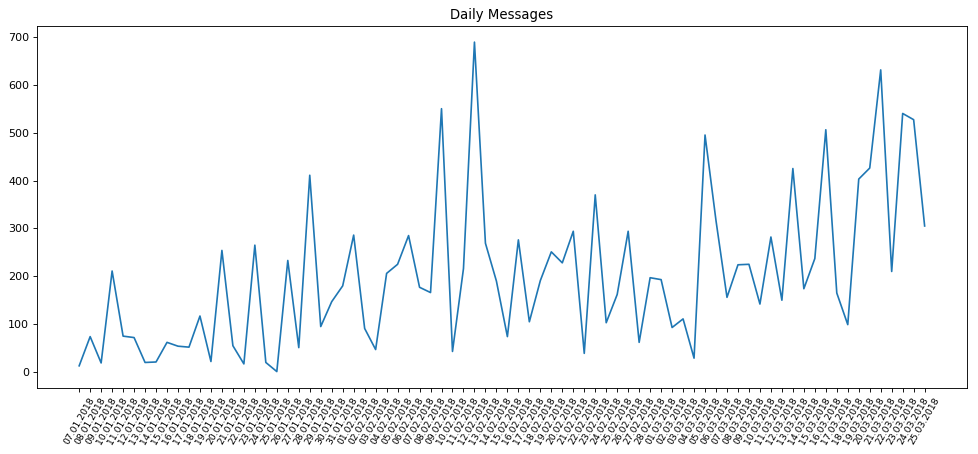

In [24]:
sorted_total_m_by_date = sorted(total_m_by_date.items(), key=lambda x: datetime.datetime.strptime(x[0], "%d.%m.%Y"))
dates = [item[0] for item in sorted_total_m_by_date]
counts = [item[1] for item in sorted_total_m_by_date]
# plt.plot(x=list(.keys()), y=list(total_m_by_date.values()))
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(counts)
plt.xticks(range(len(counts)), dates, size='small', rotation=60)
plt.title("Daily Messages")
# plt.xticks(len(total_m_by_date.values()), list(total_m_by_date.keys()))

In [28]:
b = daily_m["Burak"].to_dict()
h = daily_m["Hazal"].to_dict()
for date in dates:
    if date not in h:
        h[date] = 0
    if date not in b:
        b[date] = 0
sorted_b = sorted(b.items(), key=lambda x: datetime.datetime.strptime(x[0], "%d.%m.%Y"))
sorted_h = sorted(h.items(), key=lambda x: datetime.datetime.strptime(x[0], "%d.%m.%Y"))
b_counts = [item[1] for item in sorted_b]
h_counts = [item[1] for item in sorted_h]

Text(0.5,1,'Daily Messages')

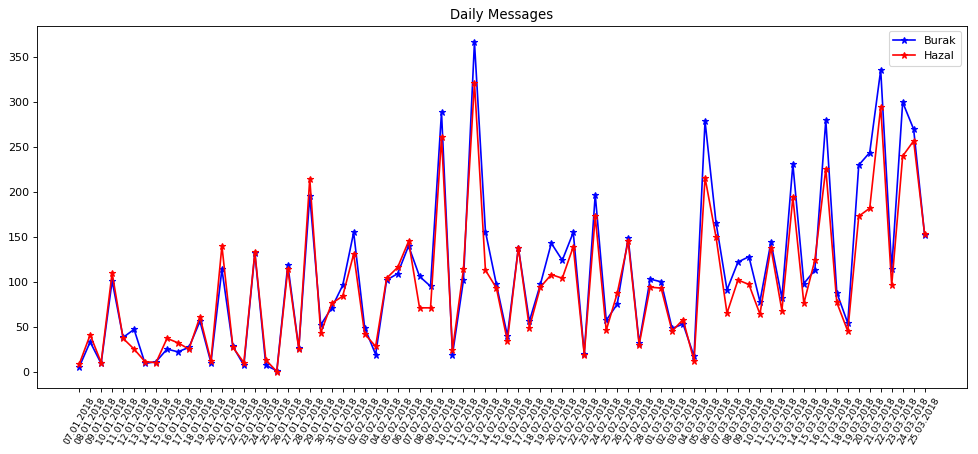

In [29]:
# plt.plot(x=list(.keys()), y=list(total_m_by_date.values()))
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(dates)), b_counts, "b-*", label="Burak")
plt.plot(range(len(dates)), h_counts, "r-*", label="Hazal")
plt.legend()
plt.xticks(range(len(dates)), dates, size='small', rotation=60)
plt.title("Daily Messages")
# plt.xticks(len(total_m_by_date.values()), list(total_m_by_date.keys()))

In [10]:
def detect_emoji(message):
    emoji_list = []
    for char in message:
        if char in emoji.UNICODE_EMOJI:
            emoji_list.append(char)
    return emoji_list

In [11]:
chat["Emoji"] = chat["Message"].apply(lambda x: detect_emoji(x))
chat["Emoji_Count"] = chat["Emoji"].apply(lambda x: len(x))

In [12]:
b_emoji = chat[chat["Name"]=="Burak"]["Emoji"].tolist()
h_emoji = chat[chat["Name"]=="Hazal"]["Emoji"].tolist()

In [13]:
b_dict = dict()
for emoji in b_emoji:
    for e in emoji:
        if len(e)>0:
            if e not in b_dict:
                b_dict[e] = 0
            b_dict[e] += 1
sorted_b_dict = sorted(b_dict.items(), key=lambda x: x[1], reverse=True)
sorted_b_dict

[('😂', 81),
 ('😅', 42),
 ('😳', 31),
 ('☺', 25),
 ('😒', 24),
 ('😴', 21),
 ('🙄', 20),
 ('😘', 19),
 ('👋', 16),
 ('🙈', 16),
 ('😎', 15),
 ('🤔', 15),
 ('😜', 14),
 ('😢', 14),
 ('❤', 8),
 ('😇', 8),
 ('😱', 7),
 ('👍', 7),
 ('😀', 6),
 ('💪', 5),
 ('🙃', 5),
 ('😔', 5),
 ('😐', 3),
 ('👀', 3),
 ('🎈', 3),
 ('👎', 2),
 ('😊', 2),
 ('😉', 2),
 ('🙏', 2),
 ('🙂', 2),
 ('😏', 2),
 ('🍭', 2),
 ('🎉', 1),
 ('👌', 1),
 ('☹', 1),
 ('😈', 1),
 ('🤗', 1),
 ('😲', 1),
 ('😍', 1),
 ('🤥', 1),
 ('😌', 1),
 ('🏃', 1),
 ('♂', 1)]

In [14]:
h_dict = dict()
for emoji in h_emoji:
    for e in emoji:
        if len(e)>0:
            if e not in h_dict:
                h_dict[e] = 0
            h_dict[e] += 1
sorted_h_dict = sorted(h_dict.items(), key=lambda x: x[1], reverse=True)
sorted_h_dict

[('😅', 159),
 ('☺', 130),
 ('😂', 93),
 ('😔', 65),
 ('😳', 59),
 ('😃', 46),
 ('😝', 34),
 ('🤔', 25),
 ('🙈', 23),
 ('❤', 14),
 ('😒', 11),
 ('😇', 11),
 ('😄', 10),
 ('😘', 10),
 ('😱', 7),
 ('😉', 6),
 ('😎', 6),
 ('😏', 5),
 ('🎈', 4),
 ('😍', 3),
 ('🏼', 3),
 ('😜', 3),
 ('😊', 3),
 ('😢', 3),
 ('🏻', 2),
 ('👷', 2),
 ('♀', 2),
 ('🙃', 2),
 ('💪', 2),
 ('😀', 1),
 ('🙌', 1),
 ('☀', 1),
 ('😈', 1),
 ('👾', 1),
 ('🍭', 1),
 ('👌', 1),
 ('😴', 1),
 ('🤐', 1),
 ('🏽', 1)]

<Container object of 39 artists>

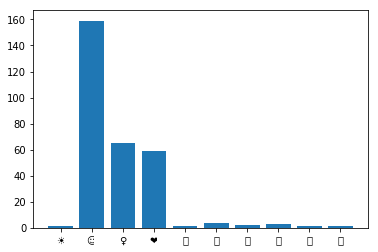

In [15]:
plt.bar(x=[item[0] for item in sorted_h_dict], height=[item[1] for item in sorted_h_dict])